### Инструкция

Выберите одно из окружение AI Gym - Classic Control (кроме CartPole) или Box2D - https://gym.openai.com/envs/

Изучите действия агента в заданной среде. Постройте алгоритм машинного обучения с подкреплением, который решает поставленную задачу после нужного количества обучающих эпизодов.

Выложите полный код решения в вашем репозитории GitHub. Приложите ссылку на решение в репозитории в ответе к заданию.

## Выбрано было окружение Frozen Lake

### Описание 

Игра начинается с того, что игрок находится в локации [0,0] мира frozen lake grid, а цель расположена на дальнем конце мира, например, [3,3] для среды 4x4.

Лунки во льду распределяются в заданных местах при использовании заранее определенной карты или в случайных местах при создании случайной карты.

Игрок делает ходы до тех пор, пока они не достигнут цели или не упадут в лунку.

Озеро скользкое (если не отключено), поэтому игрок иногда может двигаться перпендикулярно намеченному направлению (см. is_slippery).

Случайно сгенерированные миры всегда будут иметь путь к цели.

### is_slippery
is_slippery=True: Если true, то игрок будет двигаться в заданном направлении с вероятностью 1/3, в противном случае он будет двигаться в любом перпендикулярном направлении с равной вероятностью 1/3 в обоих направлениях.

Например, если действие оставлено и is_slippery имеет значение True, то:

* P(перемещение влево)=1/3
* P(движение вверх)=1/3
* P(движение вниз)=1/3

#### Будем использовать is_slippery=False

### Подключение библиотек и загрузка окружения

Размер поля выберем 8x8, скольжение отключим. 

render_mode в данном окружении есть ['human', 'ansi', 'rgb_array'],  выберем ansi, при помощи функции можно выводить текстовую картинку, для наглядности в обучении или в итоговом проходе.

desc=None: Используется для указания непредустановленных карт. Указание пользовательской карты desc=["SFFF", "FHFH", "FFFH", "HFFG"].

Случайно сгенерированную карту можно указать, вызвав функцию .generate_random_map. desc=generate_random_map(size=8)

map_name="4x4": ID для использования любой из предварительно загруженных карт.



In [415]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep




In [416]:
# env = gym.make("FrozenLake-v1", is_slippery=False, render_mode='human')
env = gym.make("FrozenLake8x8-v1", is_slippery=False)
# env = gym.make("FrozenLake-v1", is_slippery=False)




### Логика
 
Дойти до подарка не упав в воду.

Возможные действия:
* Движение по одной клетке - направление 0,1,2,3
* Попадание в воду  - конец игры
* Обнаружение подарка - награда 1.0, конец игры

### Реализуем  e-жадную политику  


### Q-обучение
Создадим Q-таблицу из дискретных состояний среды и возможных действий

In [417]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])
q_table.shape

(64, 4)

ε-жадная стратегия и обновление таблицы

In [418]:
eps = 0.1
lr = 0.8
n_episodes = 10000

In [419]:
def policy (state, env, eps):
    if np.random.random() < eps: 
        action = env.action_space.sample() # explore
    else:
        action = np.argmax(q_table[state])
    return action


def policy_update (current_state, new_state, reward, action, lr):
    q_table[current_state][action] = (1-lr)*q_table[current_state][action] + lr*(reward + np.max(q_table[new_state]))

In [420]:
def print_running_mean(training_rewards, i):
    clear_output(wait=True)
    plt.figure(figsize=(18, 4))
    plt.plot(pd.Series(training_rewards[:i]).rolling(100).mean())
    plt.title("Сумма наград за последние 100 эпизодов")
    plt.show()


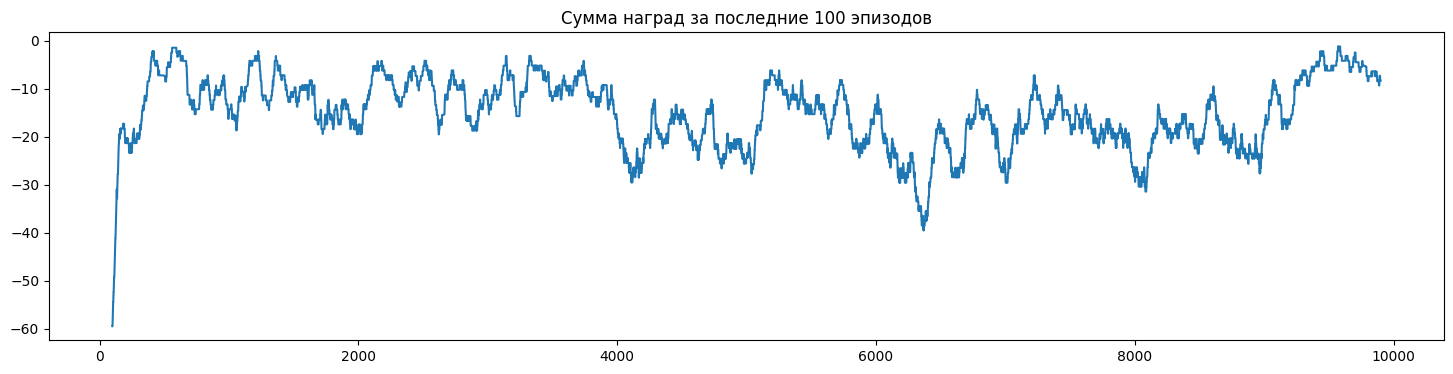

In [421]:
training_rewards = np.zeros(n_episodes)
for e in range(n_episodes):
        current_state, info = env.reset()
        rew = 0
        while True:
            action = policy(current_state, env, eps)
            rew += 0.001
            obs, reward, done, trunc, info = env.step(action) 
            new_state = obs
            if done == True and reward == 0:
                 reward = - 100
            #      print("Провал", reward)
            # print("Награда", reward)
            reward -= rew

            policy_update(current_state, new_state, reward, action, lr)
            current_state = new_state
            training_rewards[e] += reward
            if done:
                break

        if e % 100 == 0:
            print_running_mean(training_rewards, e)

### Оптимизированная e-жадная 

Создадим q-таблицу

In [422]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])
q_table.shape

(64, 4)

Определим параметры

Эписилон возьмем максимальный и будем уменьшать по мере обучения 

In [423]:
eps = 1
min_eps = 0.1  # эпислон при котором нет результатов от разведки
lr = 0.1  # поставим достаточно низкое значение отдав приоритет разведке
n_episodes = 10000

In [424]:
def policy (state, env, eps):
    if np.random.random() < eps: 
        action = env.action_space.sample() # explore
    else:
        action = np.argmax(q_table[state])
    return action


def policy_update (current_state, new_state, reward, action, lr):
    q_table[current_state][action] = (1-lr)*q_table[current_state][action] + lr*(reward + np.max(q_table[new_state]))

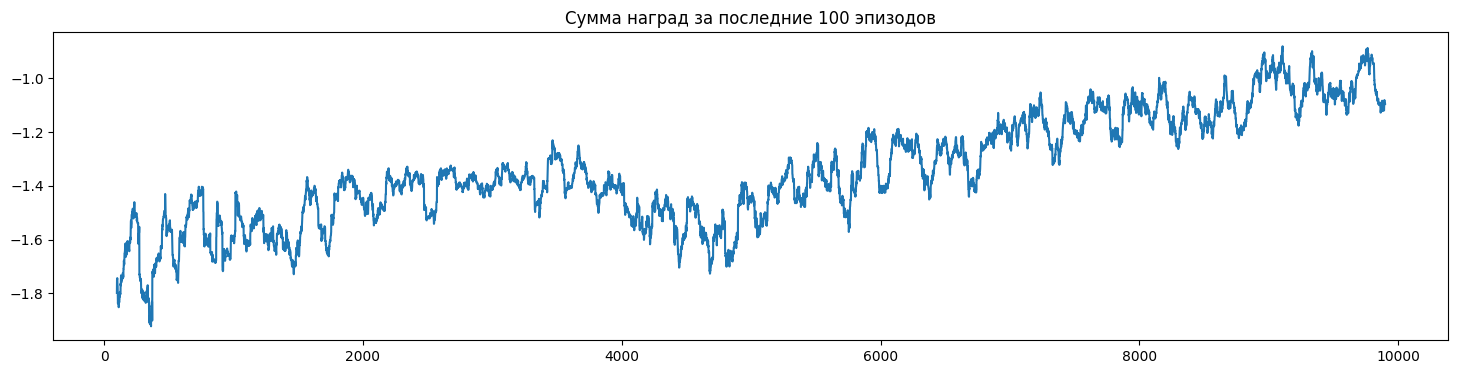

In [425]:
training_rewards = np.zeros(n_episodes)
for e in range(n_episodes):
        current_state, info = env.reset()
        rew = 0
        while True:
            action = policy(current_state, env, eps)
            rew += 0.001
            obs, reward, done, trunc, info = env.step(action) 
            new_state = obs
            if done == True and reward == 0:
                 reward = - 1
            reward -= rew
            #      print("Провал", reward)
            # print("Награда", reward)
            policy_update(current_state, new_state, reward, action, lr)
            training_rewards[e] += reward            
            current_state = new_state
            if done:
                eps *= 0.99995
                lr *= 0.99995
                break

        if e % 100 == 0:
            print_running_mean(training_rewards, e)

In [426]:
print(eps, lr)
env.close()

0.6065230778740716 0.060652307787407767


Проверка e-жадной стратегии

In [427]:

def display_trajectory(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)

In [428]:
env = gym.make("FrozenLake8x8-v1", is_slippery=False, render_mode='human')
env.reset()

frames = [] # for animation
timesteps = 0
state, info = env.reset()
while True:
    action = np.argmax(q_table[state])
    state, reward, done, trunc, info = env.step(action)
    frames.append({
        'frame': env.render(),
        'state': state,
        'reward': reward
        }
    )

    timesteps += 1
    if done:
        break
        
display_trajectory(frames)

None
Timestep: 14
State: 63
Reward: 1.0


In [429]:
env.close()